# Reproducible Analysis of Politician Claims: A Python Demo for R2CASS@ICWSM

This Jupyter Notebook demonstrates a reproducible analysis of a subset of the LIAR dataset, focusing on politician statements and their fact-checking truth ratings. This analysis is designed to be run seamlessly via Binder, ensuring reproducibility across different environments.

**Goal:** To load a dataset of politician claims, analyze the distribution of their truth ratings, and visualize the results.

## 1. Setup and Data Loading

First, we'll import the necessary libraries (`pandas` for data manipulation, `matplotlib.pyplot` and `seaborn` for plotting) and then load our dataset.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define column names as per LIAR dataset README, since our TSV has no header
column_names = [
    'ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title',
    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

# Load the dataset.tsv file
# The 'sep=\t' specifies tab-separated values.
# 'header=None' indicates no header row.
# 'names=column_names' assigns our custom column names.
df = pd.read_csv('../data/dataset.tsv', sep='\t', header=None, names=column_names)

print("Dataset loaded successfully!")
print(f"Number of claims: {len(df)}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset loaded successfully!
Number of claims: 10240

First 5 rows of the dataset:
           ID        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                             subjects         speaker     speaker_job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jo

## 2. Analyze Distribution of Truth Ratings

Let's examine how many claims fall into each truth rating category (`label` column).

In [24]:
# Define the desired order for truth labels
truth_label_order = [
    "pants-fire",
    "false",
    "barely-true",
    "half-true",
    "mostly-true",
    "true"
]

# Convert the 'label' column to a Categorical type with the specified order
df['label'] = pd.Categorical(df['label'], categories=truth_label_order, ordered=True)

# Now, value_counts() will respect this order
truth_rating_counts = df['label'].value_counts().sort_index()

print("\nDistribution of Truth Ratings:")
print(truth_rating_counts)


Distribution of Truth Ratings:
pants-fire      839
false          1995
barely-true    1654
half-true      2114
mostly-true    1962
true           1676
Name: label, dtype: int64


## 3. Visualize Truth Rating Distribution

A bar chart provides a clear visual summary of the truth rating distribution. We'll order the labels for better readability.

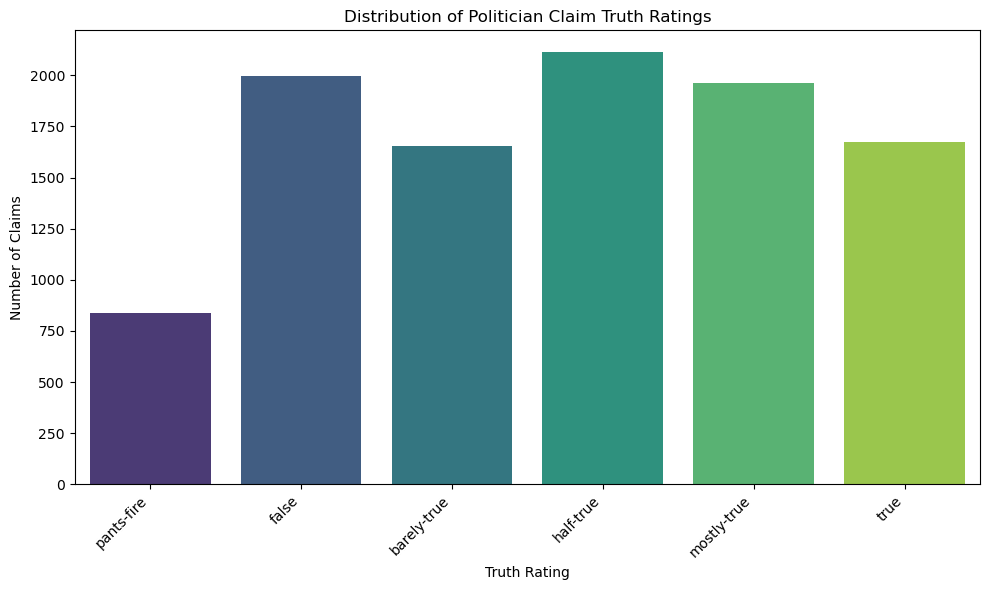

In [25]:

plt.figure(figsize=(10, 6))
sns.barplot(x=truth_rating_counts.index, y=truth_rating_counts.values, palette='viridis')
plt.title('Distribution of Politician Claim Truth Ratings')
plt.xlabel('Truth Rating')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the plot to a file that can be viewed in the Binder environment
plt.savefig('truth_ratings_distribution.png')
plt.show()

## 4. Analyze Claims by Party Affiliation

Let's also see the distribution of claims by the speaker's political party.

In [26]:
# Clean party_affiliation data: replace empty strings/NaN with 'Unknown'
df['party_affiliation'] = df['party_affiliation'].replace('', 'unknown').fillna('unknown')
party_counts = df['party_affiliation'].value_counts().sort_index()

print("\nDistribution of Claims by Party Affiliation:")
print(party_counts)


Distribution of Claims by Party Affiliation:
Moderate                           1
activist                          39
business-leader                    9
columnist                         35
constitution-party                 1
democrat                        3336
democratic-farmer-labor            1
education-official                 2
government-body                    1
green                              3
independent                      147
journalist                        38
labor-leader                      11
liberal-party-canada               1
libertarian                       40
newsmaker                         56
none                            1744
ocean-state-tea-party-action       1
organization                     219
republican                      4497
state-official                    20
talk-show-host                    26
tea-party-member                  10
unknown                            2
Name: party_affiliation, dtype: int64


## 5. Visualize Claims by Party Affiliation

Finally, a bar chart for party affiliation to complete our brief exploration.

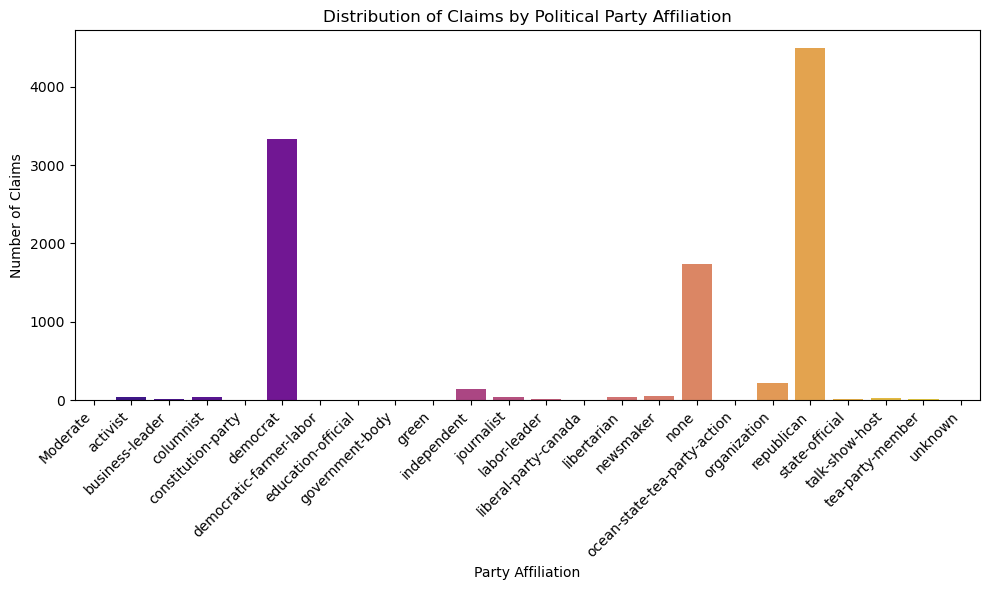

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x=party_counts.index, y=party_counts.values, palette='plasma')
plt.title('Distribution of Claims by Political Party Affiliation')
plt.xlabel('Party Affiliation')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('party_affiliation_distribution.png')
plt.show()

## 6. Truth Ratings by Party Affiliation (Stacked Bar Chart)

To gain deeper insights, let's visualize the distribution of truth ratings, broken down by the speaker's political party. This stacked bar chart will allow us to see the composition of true/false claims within each party.

In [29]:
# 1. Clean 'party_affiliation': Replace empty strings/NaN with 'unknown'
#    And also filter out 'none' as per R code's filter(!is.na, != "none")
df_filtered = df[df['party_affiliation'].astype(str).str.lower() != 'none'].copy()
df_filtered['party_affiliation'] = df_filtered['party_affiliation'].replace('', 'unknown').fillna('unknown')

# 2. Lumping less frequent party affiliations (similar to fct_lump_n)
top_n = 10 # Define how many top parties you want to keep
party_counts_for_lumping = df_filtered['party_affiliation'].value_counts()
top_parties = party_counts_for_lumping.head(top_n).index

df_filtered['party_affiliation_grouped'] = df_filtered['party_affiliation'].apply(
    lambda x: x if x in top_parties else 'Other (Lumped)'
)

# Ensure 'party_affiliation_grouped' is also a categorical with order if desired,
# but for bar plots, pandas usually handles it well by frequency if not specified.
# For consistency with fct_infreq, we can sort it by frequency for plotting.
party_order_freq = df_filtered['party_affiliation_grouped'].value_counts().index
df_filtered['party_affiliation_grouped'] = pd.Categorical(
    df_filtered['party_affiliation_grouped'],
    categories=party_order_freq,
    ordered=True
)


# Group by the new grouped party affiliation and the ordered truth rating
# and calculate counts, then unstack
party_truth_counts_raw = df_filtered.groupby(['party_affiliation_grouped', 'label']).size().unstack(fill_value=0)

# 3. Calculate proportions (similar to position="fill" in ggplot2)
# Divide each row by its sum to get proportions
party_truth_proportions = party_truth_counts_raw.div(party_truth_counts_raw.sum(axis=1), axis=0)

print("\nTruth Ratings Proportions by Party (Top 10, Ordered by Veracity):")
print(party_truth_proportions)


Truth Ratings Proportions by Party (Top 10, Ordered by Veracity):
label                      pants-fire     false  barely-true  half-true  \
party_affiliation_grouped                                                 
republican                   0.084501  0.228597     0.185012   0.197910   
democrat                     0.045863  0.153177     0.138789   0.224820   
organization                 0.077626  0.228311     0.205479   0.269406   
independent                  0.020408  0.122449     0.129252   0.183673   
Other (Lumped)               0.079365  0.174603     0.063492   0.222222   
newsmaker                    0.053571  0.160714     0.125000   0.196429   
libertarian                  0.075000  0.150000     0.100000   0.300000   
activist                     0.000000  0.179487     0.179487   0.230769   
journalist                   0.026316  0.263158     0.131579   0.157895   
columnist                    0.028571  0.285714     0.142857   0.085714   
talk-show-host               0.15

Plot saved as 'party_vs_truth_stacked_proportions.png'


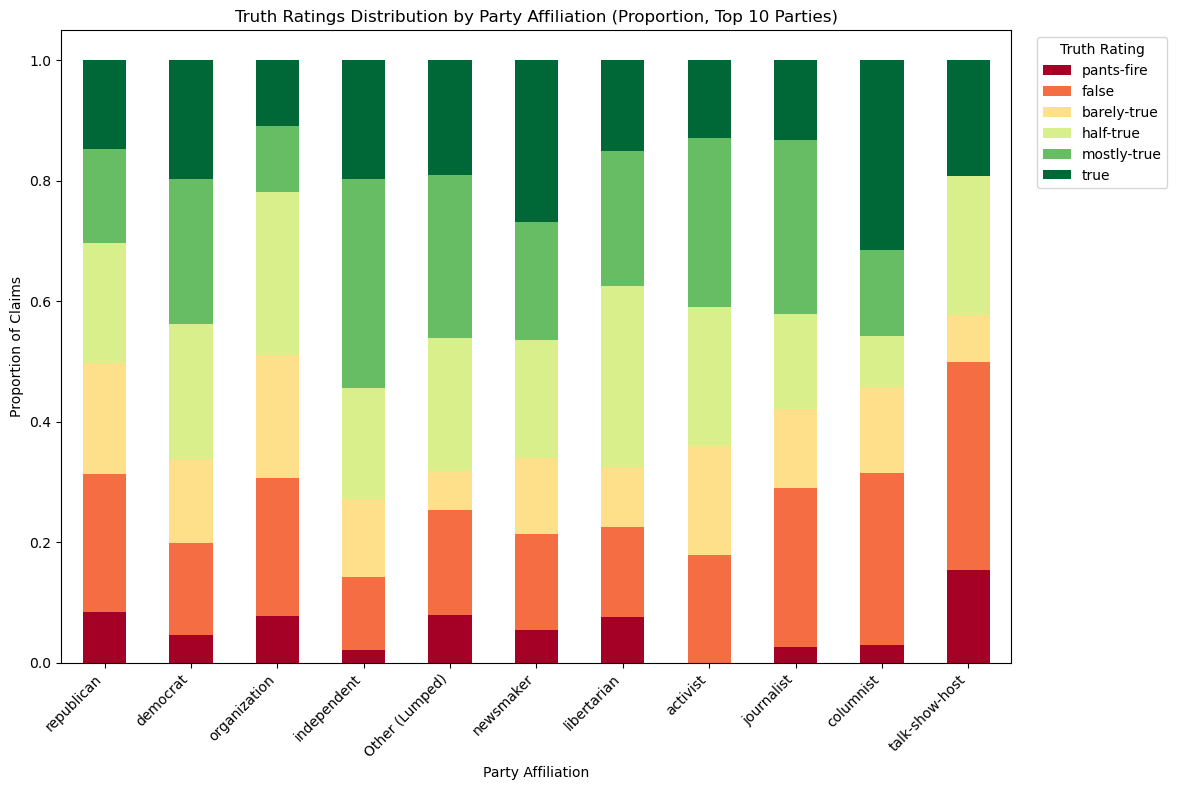

In [30]:
plt.figure(figsize=(14, 8)) # Adjusted figure size for better readability
# Plot the proportions. The 'label' (columns) are already ordered from previous step.
# Using RdYlGn for a red-to-green gradient (false to true), matching R.
party_truth_proportions.plot(kind='bar', stacked=True, ax=plt.gca(), cmap='RdYlGn')
plt.title('Truth Ratings Distribution by Party Affiliation (Proportion, Top 10 Parties)')
plt.xlabel('Party Affiliation')
plt.ylabel('Proportion of Claims')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Truth Rating', bbox_to_anchor=(1.02, 1), loc='upper left') # Adjust legend position
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend

# Save the plot (before plt.show())
plt.savefig('party_vs_truth_stacked_proportions.png', dpi=300) # Added dpi for higher resolution
print("Plot saved as 'party_vs_truth_stacked_proportions.png'")

plt.show()

## Conclusion

This notebook demonstrates how to load, analyze, and visualize data related to politician claims and their truth ratings in a reproducible Python environment. By packaging this with Binder, we ensure anyone can rerun this analysis with ease.

Feel free to modify the code, add new analyses, or explore other aspects of the dataset!